In [1]:
import pandas as pd
import numpy as np
import math
pd.set_option('display.max_colwidth', 100)
import matplotlib.pyplot as plt

### Caricamento del dataset

In [2]:
data = pd.read_csv("backup_corpus/corpus_intro_final.csv")

In [3]:
corpus = data[['Article Title', 'Abstract', 'Introduction', 'Publication Year', 'Times Cited, All Databases']]

In [4]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Article Title               260 non-null    object
 1   Abstract                    260 non-null    object
 2   Introduction                259 non-null    object
 3   Publication Year            260 non-null    int64 
 4   Times Cited, All Databases  260 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 10.3+ KB


### Rimozione documenti vuoti

In [5]:
corpus = corpus.dropna() #remove nan values
corpus = corpus.reset_index(drop=True) #reset index for removed elements
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Article Title               259 non-null    object
 1   Abstract                    259 non-null    object
 2   Introduction                259 non-null    object
 3   Publication Year            259 non-null    int64 
 4   Times Cited, All Databases  259 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 10.2+ KB


### Aggiunta titolo, introduzione e abstract al corpus

Dopo aver arricchito il dataset contenente i documenti scientifici con le introduzioni, si procede selezionando solamente le feature contenenti informazioni utili per poter estrarre i topic latenti dal corpus. In particolare, per questo studio si è scelto di combinare il titolo, l'abstract e l'introduzione concatenandoli; questa operazione è possibile poichè i modelli per topic trattano il testo come una bag-of-words e, pertanto, l'ordine delle parole è indifferente.

In [6]:
corpus['Introduction'] = corpus.loc[:, 'Article Title'] + ' ' + corpus.loc[:, 'Abstract'] + '' + corpus.loc[:, 'Introduction']

## Descrizione dataset

In [56]:
import seaborn as sns
sns.set_theme()

In [8]:
corpus = corpus.rename(columns={"Publication Year": "Year", "Article Title": "Title", "Times Cited, All Databases": "Citations"})

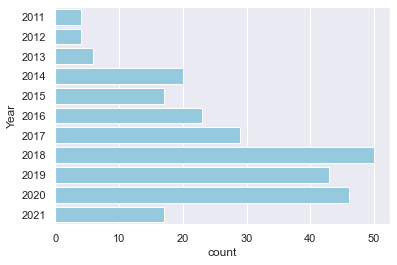

In [57]:
ax = sns.countplot(y="Year", data=corpus, color='skyblue')

### Preprocessing

Tutte le tecniche di NLP (Natural Language Processing) necessitano di una fase preliminare di pulizia dei dati, nella quale si rimuovono le parti di testo che non portano informazione utile ma, anzi, potrebbero peggiorare le prestazioni del modello [inserire riferimento al capitolo sul preprocessing nel software].

Il testo viene preliminarmente trasformato in minuscolo, poi vengono rimossi i numeri e tutti i caratteri speciali, filtrando dunque tutto ciò che non è una parola di linguaggio naturale.

In [10]:
# lowercase
corpus['Introduction'] = corpus['Introduction'].str.lower()

# remove numbers
corpus['Introduction'] = corpus['Introduction'].str.replace(r'[0-9]+', ' ', regex=True)

# remove link
corpus['Introduction'] = corpus['Introduction'].str.replace(r'http\S+', ' ', regex=True)

# remove punctuaction and special characters except dashes
corpus['Introduction'] = corpus['Introduction'].str.replace(r'[^\w\s\-]', ' ', regex=True)

#remove single dashes preserving intra-word
corpus['Introduction'] = corpus['Introduction'].str.replace('-(?!\w)|(?<!\w)-', ' ', regex=True)

#remove single letter
corpus['Introduction'] = corpus['Introduction'].str.replace('\\b\\w\\s', '', regex=True)

# remove extra spaces
corpus['Introduction'] = corpus['Introduction'].str.replace(' +', ' ', regex=True)

corpus['Introduction']

0      deep-learning-enabled security issues in the internet of things in order to explore the applicat...
1      robust spammer detection using collaborative neural network in internet-of-things applications s...
2      robust learning-enabled intelligence for the internet of things survey from the perspectives of ...
3      multicloud-model-based many-objective intelligent algorithm for efficient task scheduling in int...
4      model for joint planning of production and distribution of fresh produce in agricultural interne...
                                                      ...                                                 
254    an overview of the internet of things for people with disabilities currently over billion people...
255    smart community an internet of things application in this article we introduce an internet of th...
256    siot giving social structure to the internet of things the actual development of the internet of...
257    securing the internet of thing

In [11]:
corpus['IntroLen'] = corpus['Introduction'].map(lambda x: len(x.split()))

In [12]:
print('Lunghezza media documenti corpus con abstract e introduzione:', np.mean(corpus['IntroLen']))

Lunghezza media documenti corpus con abstract e introduzione: 1064.4903474903474


### Rimozione stopwords e stemming

In [13]:
import nltk
#nltk.download('punkt')
from nltk import word_tokenize 
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer

Un altro passo fondamentale facente parte del preprocessing del testo è la rimozione delle stopwords, parole molto frequenti che hanno poco significato semantico ma che vengono utilizzate nel linguaggio naturale; un esempio di stopwords è dato dagli articoli e dalle congiunzioni.
Nel corpus sono però presenti altre parole molto frequenti presenti nella maggior parte dei documenti e che, dunque, non risultano utili per estrarre conoscenza. Le parole indicate sono state aggiunte alle stopwords in modo tale da essere filtrate prima dell'inserimento del corpus all'interno del modello.

In [14]:
stop = stopwords.words('english')
stop.extend(['et', 'al', 'iot', 'data', 'internet', 'devices', 'proposed',
             'things', 'network', 'applications', 'section', 
             'used', 'systems', 'system', 'developed', 'paper'])
stemmer = SnowballStemmer("english")

In [15]:
# remove stopwords
corpus['Introduction'] = corpus['Introduction'].apply(lambda x: [item for item in str(x).split() if item not in stop])

L'operazione di stemming, invece, ha lo scopo di rimuovere le forme flesse delle parole così da ridurre la dimensionalità andando a raggruppare tutte le parole che hanno la stessa radice. [ ricondursi al paragrafo in cui è spiegato].

In [16]:
# stemming
stemmed_documents = corpus['Introduction'].apply(lambda x: [stemmer.stem(y) for y in x]) 

### Ricostruzione parole dopo stemming

Dopo aver effettuato lo stemming le parole vengono ricondotte alla propria radice e questo ne riduce l'interpretabilità. Per ovviare a questo problema le parole vengono ricostruite utilizzando la forma flessa più frequente associato ad ogni termine su cui è stato applicato lo stemming.

In [17]:
def unstem(stemmed_documents, non_stemmed_documents):
    stemmed_words = list()
    non_stemmed_words = list()
    
    # convert matrix of stemmed documents into lists of terms
    for i in stemmed_documents:
        stemmed_words = stemmed_words + i
        
    # convert matrix of stemmed documents into lists of terms
    for i in non_stemmed_documents:
        non_stemmed_words = non_stemmed_words + i
        
    # list with no duplicates of words
    stemmed_words_list = list(set(stemmed_words))
    
    # create a list with the correct non-stemmed words
    correct_words_list = list()
    
    # dictionary with normal word -> stemmed word
    w_dict = dict(zip(non_stemmed_words, stemmed_words))
    
    # loop all stemmed words
    for word in stemmed_words_list:
        word_list = [k for k in w_dict.keys() if w_dict[k] == word]
        right_word = (max(word_list, key=word_list.count))
        correct_words_list.append(right_word)
        
    # create a dictionary with stemmed word -> correct word
    dictionary = dict(zip(stemmed_words_list, correct_words_list))
    
    unstemmed_documents = pd.Series(np.zeros(len(stemmed_documents)))
    # map all stemmed words to the correct one
    for i in range(0, len(stemmed_documents)):
        unstemmed_documents[i] = [*map(dictionary.get, stemmed_documents[i])]
        
    return unstemmed_documents

In [18]:
# get all documents not stemmed
non_stemmed_documents = corpus['Introduction']

In [19]:
unstemmed_documents = unstem(stemmed_documents, non_stemmed_documents)
unstemmed_documents

0      [deep-learning-enabled, security, issues, order, explore, application, value, deep, learning, de...
1      [robustness, spammer, detection, using, collaborative, neural, internet-of-things, spamming, eme...
2      [robustness, learning-enabled, intelligent, survey, perspective, noisy, adversarial, example, wi...
3      [multicloud-model-based, many-objective, intelligent, algorithms, efficiency, task, scheduling, ...
4      [model, joint, planning, product, distributed, fresh, produce, agriculture, product, distributed...
                                                      ...                                                 
254    [overview, people, disabling, currently, billion, people, include, children, world, population, ...
255    [smart, communities, application, article, introduced, application, smart, communities, refer, p...
256    [siot, give, social, structure, actual, development, need, major, issues, relations, service, di...
257    [security, presently, security

## LDA perplexity

In [20]:
from tomotopy import LDAModel
from tomotopy import CTModel
from tomotopy.utils import Corpus

In [21]:
burn_in_samp = 10 # numero di campioni burnin
train_iter = 100 # train con 50 iterazioni

In [22]:
from sklearn.model_selection import KFold

In [23]:
perplexity_lda = list() # inizializzazione lista di perplexity per la visualizzazione

for i in range(2, 21):
    # inizializza fold
    kf = KFold(n_splits=5, shuffle=True)
    perplexity_list = list()
    for train_index, test_index in kf.split(unstemmed_documents):
        X_train, X_test = unstemmed_documents[train_index], unstemmed_documents[test_index]
        # creazione corpus tomotopy
        corpus_train = Corpus()
        for doc in X_train:
            corpus_train.add_doc(doc)
        # creazione modello LDA
        lda_model = LDAModel(k=i, alpha=50/i, eta=0.1, corpus=corpus_train)
        lda_model.burn_in = burn_in_samp #imposta burnin
        lda_model.train(train_iter)
        # inferenza sui documenti di test
        corpus_test = Corpus()
        for doc in X_test:
            corpus_test.add_doc(doc)
        # calcolo perpleity su test set
        topic_dist, ll = lda_model.infer(corpus_test)
        num_words = sum(X_test.map(lambda x: len(x)))
        perp = math.exp(-(np.sum(ll)/num_words))
        perplexity_list.append(perp)
    perplexity_lda.append(np.mean(perplexity_list))
    print('Perplexity media LDA con 5-fold CV con k={}: {}'.format(i, np.mean(perplexity_list)))

Perplexity media LDA con 5-fold CV con k=2: 1083.7155134134698
Perplexity media LDA con 5-fold CV con k=3: 1164.5785492649109
Perplexity media LDA con 5-fold CV con k=4: 1235.8464420874993
Perplexity media LDA con 5-fold CV con k=5: 1260.48939517028
Perplexity media LDA con 5-fold CV con k=6: 1268.913009902611
Perplexity media LDA con 5-fold CV con k=7: 1244.5969356788166
Perplexity media LDA con 5-fold CV con k=8: 1261.1229957092016
Perplexity media LDA con 5-fold CV con k=9: 1284.2372361737746
Perplexity media LDA con 5-fold CV con k=10: 1288.9426151182774
Perplexity media LDA con 5-fold CV con k=11: 1290.6195496843259
Perplexity media LDA con 5-fold CV con k=12: 1276.6625674219345
Perplexity media LDA con 5-fold CV con k=13: 1227.1478603917253
Perplexity media LDA con 5-fold CV con k=14: 1357.473158442713
Perplexity media LDA con 5-fold CV con k=15: 1285.2999616572374
Perplexity media LDA con 5-fold CV con k=16: 1248.0571654253072
Perplexity media LDA con 5-fold CV con k=17: 1245.17

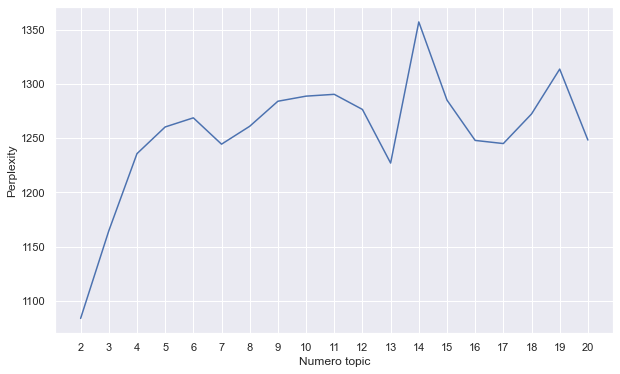

In [55]:
ax = plt.figure(figsize=(10,6))
ax = sns.lineplot(x=range(2, 21), y=perplexity_lda)
ax.set(xticks=list(range(2,21)))
ax.set_xlabel('Numero topic')
ax.set_ylabel('Perplexity')
plt.show()

## CTM perplexity

In [25]:
perplexity_ctm = list() # inizializzazione lista di perplexity per la visualizzazione

for i in range(2, 21):
    # inizializza fold
    kf = KFold(n_splits=5, shuffle=True)
    perplexity_list = list()
    for train_index, test_index in kf.split(unstemmed_documents):
        X_train, X_test = unstemmed_documents[train_index], unstemmed_documents[test_index]
        # creazione corpus tomotopy
        corpus_train = Corpus()
        for doc in X_train:
            corpus_train.add_doc(doc)
        # creazione modello LDA
        ctm_model = CTModel(k=i, smoothing_alpha=50/i, eta=0.1, corpus=corpus_train) # costruzione modello
        ctm_model.burn_in = burn_in_samp #imposta burnin
        ctm_model.train(train_iter)
        # inferenza sui documenti di test
        corpus_test = Corpus()
        for doc in X_test:
            corpus_test.add_doc(doc)
        # calcolo perpleity su test set
        topic_dist, ll = ctm_model.infer(corpus_test)
        num_words = sum(X_test.map(lambda x: len(x)))
        perp = math.exp(-(np.sum(ll)/num_words))
        perplexity_list.append(perp)
    perplexity_ctm.append(np.mean(perplexity_list))
    print('Perplexity media CTM con 5-fold CV con k={}: {}'.format(i, np.mean(perplexity_list)))

Perplexity media CTM con 5-fold CV con k=2: 534.6489187122933
Perplexity media CTM con 5-fold CV con k=3: 419.20922600717824
Perplexity media CTM con 5-fold CV con k=4: 360.5933273605881
Perplexity media CTM con 5-fold CV con k=5: 318.92853891906725
Perplexity media CTM con 5-fold CV con k=6: 297.5593927071076
Perplexity media CTM con 5-fold CV con k=7: 276.9262332204335
Perplexity media CTM con 5-fold CV con k=8: 263.7171384234045
Perplexity media CTM con 5-fold CV con k=9: 254.15635569630967
Perplexity media CTM con 5-fold CV con k=10: 242.51401435425169
Perplexity media CTM con 5-fold CV con k=11: 239.4803794603231
Perplexity media CTM con 5-fold CV con k=12: 230.75590514412042
Perplexity media CTM con 5-fold CV con k=13: 229.54360753092732
Perplexity media CTM con 5-fold CV con k=14: 226.07344586026346
Perplexity media CTM con 5-fold CV con k=15: 222.0934971354293
Perplexity media CTM con 5-fold CV con k=16: 218.11115803073454
Perplexity media CTM con 5-fold CV con k=17: 217.559137

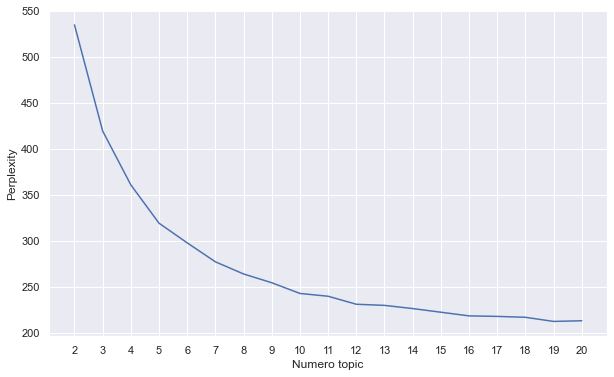

In [54]:
ax = plt.figure(figsize=(10,6))
ax = sns.lineplot(x=range(2, 21), y=perplexity_ctm)
ax.set(xticks=list(range(2,21)))
ax.set_xlabel('Numero topic')
ax.set_ylabel('Perplexity')
plt.show()

## Coherence

In [27]:
from tomotopy.coherence import Coherence

In [28]:
# corpus completo con tutti i documenti
corpus_total = Corpus()
for doc in unstemmed_documents:
    corpus_total.add_doc(doc)

## Coherence LDA

In [29]:
coherence_lda = list() # inizializza lista di coherence per la visualizzazione

for i in range(3, 15):
    # creazione modello LDA e train con tutti i documenti
    lda_model = LDAModel(k=i, alpha=50/i, eta=0.1, seed=12345, corpus=corpus_total) # costruzione modello
    lda_model.burn_in = burn_in_samp #imposta burnin
    lda_model.train(train_iter) # iterazioni di train
    coh = Coherence(lda_model, coherence='c_v')
    average_coherence = coh.get_score()
    coherence_lda.append(average_coherence)
    print('Coherence LDA c_v con k={} = {}'.format(i, average_coherence))

Coherence LDA c_v con k=3 = 0.5165354248136281
Coherence LDA c_v con k=4 = 0.5093549749813974
Coherence LDA c_v con k=5 = 0.5054014691524208
Coherence LDA c_v con k=6 = 0.5386133569894204
Coherence LDA c_v con k=7 = 0.5650945150426455
Coherence LDA c_v con k=8 = 0.5379471155116335
Coherence LDA c_v con k=9 = 0.5534022974471251
Coherence LDA c_v con k=10 = 0.5389863784611225
Coherence LDA c_v con k=11 = 0.5423887267708778
Coherence LDA c_v con k=12 = 0.58881738781929
Coherence LDA c_v con k=13 = 0.5744883591882312
Coherence LDA c_v con k=14 = 0.5915310750582388


<AxesSubplot:>

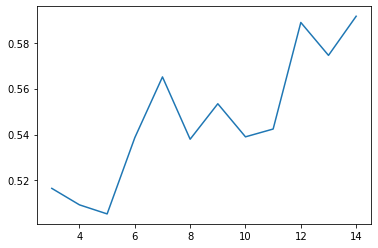

In [30]:
sns.lineplot(x=range(3, 15), y=coherence_lda)

## Coherence CTM

In [31]:
coherence_ctm = list() # inizializza lista di coherence per la visualizzazione

for i in range(3, 15):
    # creazione modello LDA e train con tutti i documenti
    ctm_model = CTModel(k=i, smoothing_alpha=50/i, seed=12345, eta=0.1, corpus=corpus_total) # costruzione modello
    ctm_model.burn_in = burn_in_samp #imposta burnin
    ctm_model.train(train_iter) # iterazioni di train
    coh = Coherence(ctm_model, coherence='c_v')
    average_coherence = coh.get_score()
    coherence_ctm.append(average_coherence)
    print('Coherence CTM c_v con k={} = {}'.format(i, average_coherence))

Coherence CTM c_v con k=3 = 0.38745121348959705
Coherence CTM c_v con k=4 = 0.37833925066515806
Coherence CTM c_v con k=5 = 0.366527528911829
Coherence CTM c_v con k=6 = 0.33316604278516027
Coherence CTM c_v con k=7 = 0.35739556660077404
Coherence CTM c_v con k=8 = 0.34638360610697416
Coherence CTM c_v con k=9 = 0.35523568271762795
Coherence CTM c_v con k=10 = 0.3552260970324278
Coherence CTM c_v con k=11 = 0.3519119760868224
Coherence CTM c_v con k=12 = 0.3624426298929999
Coherence CTM c_v con k=13 = 0.3454557130556518
Coherence CTM c_v con k=14 = 0.3386288596982402


<AxesSubplot:>

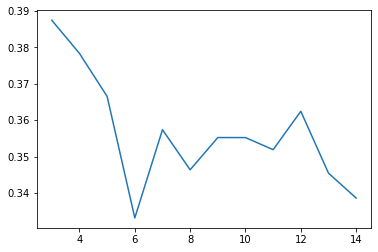

In [32]:
sns.lineplot(x=range(3, 15), y=coherence_ctm)

## Estrazione topic LDA

In [33]:
k=7
lda_model = LDAModel(k=k, alpha=50/k, eta=0.1, seed=12345, corpus=corpus_total) # costruzione modello
lda_model.burn_in = burn_in_samp #imposta burnin

#### Train del modello

In [34]:
lda_model.train(train_iter) # effettua il train

In [35]:
print('Num docs:', len(lda_model.docs), ', Vocab size:', len(lda_model.used_vocabs), ', Num words:', lda_model.num_words)
print('Removed top words:', lda_model.removed_top_words)

Num docs: 259 , Vocab size: 7791 , Num words: 154961
Removed top words: []


In [36]:
for k in range(lda_model.k):
    print('Topic #{}'.format(k))
    for word, prob in lda_model.get_topic_words(k):
        print('\t', word, prob, sep='\t')

Topic #0
		energy	0.03965230658650398
		iiot	0.026922833174467087
		industry	0.019921623170375824
		power	0.014829834923148155
		technology	0.012920414097607136
		manufacturing	0.011647467501461506
		control	0.009556196630001068
		manages	0.00937434658408165
		electricity	0.008101399056613445
		monitored	0.0077377003617584705
Topic #1
		security	0.04018525034189224
		blockchain	0.022032959386706352
		nodes	0.020315850153565407
		attacked	0.020070549100637436
		schemes	0.014722981490194798
		access	0.012220908887684345
		privacy	0.01192654762417078
		users	0.011092523112893105
		control	0.011092523112893105
		sensors	0.010405680164694786
Topic #2
		smart	0.03662388026714325
		city	0.016181277111172676
		sensors	0.014820888638496399
		information	0.010408815927803516
		environment	0.01004114281386137
		technology	0.009342564269900322
		big	0.008791055530309677
		monitored	0.00853368453681469
		using	0.008460150100290775
		human	0.00842338241636753
Topic #3
		learning	0.01872926764190197


In [37]:
for j in range(0, k+1):
    corpus['Topic_'+str(j)] = pd.Series(np.zeros(len(stemmed_documents)))

In [38]:
for i in range(0, len(corpus['Introduction'])):
    doc = lda_model.make_doc(unstemmed_documents[i])
    x = lda_model.infer(doc)
    for j in range(0, k+1):
        corpus.at[i, 'Topic_'+str(j)] = x[0][j]

In [39]:
pd.set_option('display.max_colwidth', None)

In [40]:
topic_dict = {'Topic_0': 'Industry', 'Topic_1': 'Security', 'Topic_2': 'Smart City', 'Topic_3': 'Machine learning', 
              'Topic_4': 'Wireless communication', 'Topic_5': 'Research and surveys', 'Topic_6': 'Cloud computing'}

In [41]:
corpus = corpus.rename(columns=topic_dict)

In [42]:
corpus['assignedTopic'] = corpus.iloc[:, 6:].idxmax(axis=1)

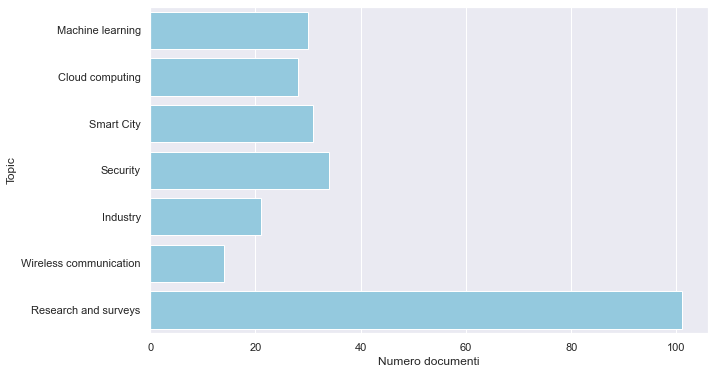

In [58]:
ax = plt.figure(figsize=(10,6))
ax = sns.countplot(y="assignedTopic", data=corpus, color="skyblue")
ax.set_xlabel('Numero documenti')
ax.set_ylabel('Topic')
plt.show()

In [44]:
corpus.loc[corpus['assignedTopic'] == 'Research and surveys'].loc[:, 'Title'].head(20)

15                                                     Internet of Things as System of Systems: A Review of Methodologies, Frameworks, Platforms, and Tools
16                                                                             The Internet of Everything: Smart things and their impact on business models
22                                                        Hybrid optimization with cryptography encryption for medical image security in Internet of Things
28                                                                   Security, privacy and trust of different layers in Internet-of-Things (IoTs) framework
30                                                            Industry 4.0 and Health: Internet of Things, Big Data, and Cloud Computing for Healthcare 4.0
38                         The dual effects of the Internet of Things (IoT): A systematic review of the benefits and risks of IoT adoption by organizations
46                                                              

## Estrazione topic CTM

In [45]:
k = 5
ctm_model = CTModel(k=k, smoothing_alpha=50/k, seed=12345, eta=0.1, corpus=corpus_total) # costruzione modello
ctm_model.burn_in = burn_in_samp #imposta burnin
ctm_model.train(train_iter) # iterazioni di train

In [46]:
print('Num docs:', len(ctm_model.docs), ', Vocab size:', len(ctm_model.used_vocabs), ', Num words:', ctm_model.num_words)
print('Removed top words:', ctm_model.removed_top_words)

Num docs: 259 , Vocab size: 7791 , Num words: 154961
Removed top words: []


In [47]:
for k in range(ctm_model.k):
    print('Topic #{}'.format(k))
    for word, prob in ctm_model.get_topic_words(k):
        print('\t', word, prob, sep='\t')

Topic #0
		energy	0.020080117508769035
		technology	0.019290929660201073
		computing	0.01850173994898796
		objects	0.016386713832616806
		new	0.016228877007961273
		efficiency	0.012030393816530704
		performance	0.011146502569317818
		connects	0.011020231992006302
		transmission	0.010104772634804249
		using	0.010104772634804249
Topic #1
		networks	0.021917525678873062
		also	0.015790248289704323
		users	0.01554015465080738
		communication	0.015383846126496792
		industry	0.014383474364876747
		study	0.013070485554635525
		resources	0.01185128279030323
		integrated	0.009881800040602684
		iiot	0.008975213393568993
		using	0.008787643164396286
Topic #2
		challenge	0.014416908845305443
		nodes	0.014005088247358799
		discussed	0.013434873893857002
		power	0.013118088245391846
		service	0.012959695421159267
		technology	0.012041017413139343
		security	0.010837232694029808
		protocol	0.010362054221332073
		algorithms	0.010298697277903557
		solution	0.009665125980973244
Topic #3
		sensors	0.0265